**Transfer Learning Experiments**

This notebook contains the transfer learning experiments done with the single trial files. Transfer learning is a technique used in machine learning which is explained more in detail later in this notebook. Experiments were ran on both static and dynamic files, including with the raw data and the data after it has been scaled. 

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Load our Dataset**

In [ ]:
%cd drive/My\ Drive/
%run LoadData.ipynb

**Imports**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt     
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler, Normalizer

**Visualization Functions**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    diff = cm.max() - cm.min()
    thresh = cm.min() + (diff/2.)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='xx-large',
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#helper function for plotting graphs of our results
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

**Models**

In [ ]:
#creates base 1D-CNN Model
def create_base_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64

  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ROWS, COLS)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name='Layer2')) 
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu', name='first_dense'))
  model.add(Dense(64, activation='relu', name='second_dense'))
  model.add(Dense(1, activation='sigmoid'))
  
  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

In [ ]:
#creates base LSTM model
def create_lstm_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64

  model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', name='first_dense'),
    tf.keras.layers.Dense(1)
  ])

  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

  return model

In [ ]:
#returns a model with transfer learning applied
def get_tl_model(base_model):
  model = Sequential()
  for layer in base_model.layers:
    #once we get to dense layers have fresh ones added
    if layer.name == 'first_dense':
      model.add(Dense(64, activation='relu', name='first_dense'))
      model.add(Dense(64, activation='relu', name='second_dense'))
      model.add(Dense(1, activation='sigmoid'))
      break
    #copy layers from base model and freeze them
    model.add(layer)
    layer.trainable = False

  #model.summary()
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  
  return model

**Train on static trials**

In [ ]:
#train on all but one user
#in this case FM01
train_set = static_trials[(np.where(static_groups != '01'))]  #np.concatenate((static_trials[67:1447], static_trials[1519:]), axis=0)
test_set = static_trials[np.where(static_groups == '01')]  #np.concatenate((static_trials[0:67], static_trials[1447:1519]), axis=0)

label_train = static_labels[(np.where(static_groups != '01'))]  #np.concatenate((static_labels[67:1447], static_labels[1519:]), axis=0)
label_test = static_labels[(np.where(static_groups == '01'))]  #np.concatenate((static_labels[0:67], static_labels[1447:1519]), axis=0)

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_base_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
 - 19s - loss: 0.9506 - accuracy: 0.4980
Epoch 2/25
 - 18s - loss: 0.7012 - accuracy: 0.5133
Epoch 3/25
 - 17s - loss: 0.7067 - accuracy: 0.5163
Epoch 4/25
 - 17s - loss: 0.6995 - accuracy: 0.5181
Epoch 5/25
 - 17s - loss: 0.6985 - accuracy: 0.5148
Epoch 6/25
 - 17s - loss: 0.6976 - accuracy: 0.4932
Epoch 7/25
 - 17s - loss: 0.7023 - accuracy: 0.5152
Epoch 8/25
 - 17s - loss: 0.6961 - accuracy: 0.5082
Epoch 9/25
 - 17s - loss: 0.6971 - accuracy: 0.5269
Epoch 10/25
 - 17s - loss: 0.7002 - accuracy: 0.5082
Epoch 11/25
 - 17s - loss: 0.6890 - accuracy: 0.5389
Epoch 12/25
 - 17s - loss: 0.6818 - accuracy: 0.5305
Epoch 13/25
 - 17s - loss: 0.6784 - accuracy: 0.5426
Epoch 14/25
 - 17s - loss: 0.6772 - accuracy: 0.5546
Epoch 15/25
 - 18s - loss: 0.6684 - accuracy: 0.5714
Epoch 16/25
 - 19s - loss: 0.6456 - accuracy: 0.5806
Epoch 17/25
 - 18s - loss: 0.6271 - accuracy: 0.6054
Epoch 18/25
 - 18s - loss: 0.6320 - accuracy: 0.6175
Epoch 19/25
 - 18s - loss: 0.5992 - accuracy: 0.6416
Ep

**Apply transfer learning and validate on remaining user**

Train on 111 samples, validate on 28 samples
Epoch 1/10
 - 1s - loss: 0.7762 - accuracy: 0.5135 - val_loss: 0.8185 - val_accuracy: 0.3214
Epoch 2/10
 - 1s - loss: 0.3413 - accuracy: 0.9009 - val_loss: 1.0833 - val_accuracy: 0.5000
Epoch 3/10
 - 1s - loss: 0.1767 - accuracy: 0.9730 - val_loss: 1.5039 - val_accuracy: 0.5000
Epoch 4/10
 - 1s - loss: 0.1043 - accuracy: 0.9820 - val_loss: 1.9288 - val_accuracy: 0.3929
Epoch 5/10
 - 1s - loss: 0.0799 - accuracy: 0.9820 - val_loss: 2.2367 - val_accuracy: 0.3929
Epoch 6/10
 - 1s - loss: 0.0744 - accuracy: 0.9820 - val_loss: 2.5227 - val_accuracy: 0.4286
Epoch 7/10
 - 1s - loss: 0.0962 - accuracy: 0.9730 - val_loss: 2.8392 - val_accuracy: 0.4286
Epoch 8/10
 - 1s - loss: 0.0435 - accuracy: 0.9910 - val_loss: 3.1056 - val_accuracy: 0.4286
Epoch 9/10
 - 1s - loss: 0.0567 - accuracy: 0.9730 - val_loss: 3.2925 - val_accuracy: 0.3929
Epoch 10/10
 - 1s - loss: 0.0453 - accuracy: 0.9820 - val_loss: 3.6396 - val_accuracy: 0.3929
Train on 111 samples, va

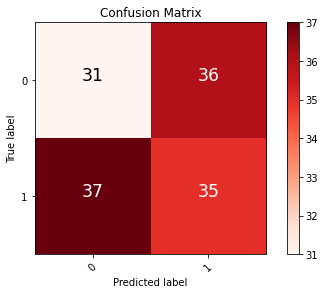

In [ ]:
n_splits = 5
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Scale data**

In [ ]:
# Scale data
for i in range(static_trials.shape[0]):
    scaler = StandardScaler()
    static_trials[i, :, :] = scaler.fit_transform(static_trials[i, :, :]) 

static_trials.shape

(2876, 1101, 64)

**Train base model on all but one user**

In [ ]:
#train on all but one user
#in this case FM01
train_set = static_trials[(np.where(static_groups != '01'))]  #np.concatenate((static_trials[67:1447], static_trials[1519:]), axis=0)
test_set = static_trials[np.where(static_groups == '01')]  #np.concatenate((static_trials[0:67], static_trials[1447:1519]), axis=0)

label_train = static_labels[(np.where(static_groups != '01'))]  #np.concatenate((static_labels[67:1447], static_labels[1519:]), axis=0)
label_test = static_labels[(np.where(static_groups == '01'))]  #np.concatenate((static_labels[0:67], static_labels[1447:1519]), axis=0)

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_base_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
 - 17s - loss: 0.7224 - accuracy: 0.4987
Epoch 2/25
 - 16s - loss: 0.6961 - accuracy: 0.5020
Epoch 3/25
 - 16s - loss: 0.6987 - accuracy: 0.5206
Epoch 4/25
 - 16s - loss: 0.6951 - accuracy: 0.4973
Epoch 5/25
 - 16s - loss: 0.6962 - accuracy: 0.4914
Epoch 6/25
 - 16s - loss: 0.6940 - accuracy: 0.4903
Epoch 7/25
 - 16s - loss: 0.6980 - accuracy: 0.5090
Epoch 8/25
 - 17s - loss: 0.6942 - accuracy: 0.4910
Epoch 9/25
 - 18s - loss: 0.6936 - accuracy: 0.5100
Epoch 10/25
 - 18s - loss: 0.6948 - accuracy: 0.5049
Epoch 11/25
 - 18s - loss: 0.6941 - accuracy: 0.5071
Epoch 12/25
 - 18s - loss: 0.6928 - accuracy: 0.5068
Epoch 13/25
 - 18s - loss: 0.6895 - accuracy: 0.5203
Epoch 14/25
 - 19s - loss: 0.6825 - accuracy: 0.5510
Epoch 15/25
 - 18s - loss: 0.6736 - accuracy: 0.5681
Epoch 16/25
 - 18s - loss: 0.6469 - accuracy: 0.5926
Epoch 17/25
 - 18s - loss: 0.6203 - accuracy: 0.6295
Epoch 18/25
 - 18s - loss: 0.5571 - accuracy: 0.6847
Epoch 19/25
 - 18s - loss: 0.4777 - accuracy: 0.7501
Ep

**Apply transfer learning to remaining user (with K fold cross validation)**

Train on 111 samples, validate on 28 samples
Epoch 1/10
 - 1s - loss: 0.7466 - accuracy: 0.4595 - val_loss: 0.7368 - val_accuracy: 0.4286
Epoch 2/10
 - 1s - loss: 0.3371 - accuracy: 0.9279 - val_loss: 1.0784 - val_accuracy: 0.4643
Epoch 3/10
 - 1s - loss: 0.0563 - accuracy: 1.0000 - val_loss: 1.2305 - val_accuracy: 0.5000
Epoch 4/10
 - 1s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 1.3882 - val_accuracy: 0.5000
Epoch 5/10
 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.5620 - val_accuracy: 0.5714
Epoch 6/10
 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.7247 - val_accuracy: 0.5714
Epoch 7/10
 - 1s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.8250 - val_accuracy: 0.5714
Epoch 8/10
 - 1s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.9378 - val_accuracy: 0.5714
Epoch 9/10
 - 1s - loss: 8.0539e-04 - accuracy: 1.0000 - val_loss: 2.0675 - val_accuracy: 0.5357
Epoch 10/10
 - 1s - loss: 7.0678e-04 - accuracy: 1.0000 - val_loss: 2.1601 - val_accuracy: 0.5357
Train on 111 sam

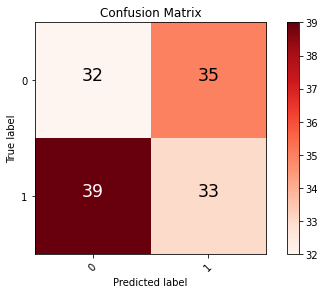

In [ ]:
n_splits = 5
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Loop through all participants giving them a chance to be the test_set**

In [ ]:
#loop through all files, giving each one chance to be test set
n_splits = 4
n_epochs = 10
batch_size = 1
verbose = 2
class_names = [0,1]

for x in range(1,25):
  #there is no second user
  if x == 2:
    continue
  
  if x < 10:
    lone_user = '0' + str(x)
  else:
    lone_user = str(x)

  train_set = static_trials[(np.where(static_groups != lone_user))]
  test_set = static_trials[(np.where(static_groups == lone_user))]

  label_train = static_labels[(np.where(static_groups != lone_user))]
  label_test = static_labels[(np.where(static_groups == lone_user))]

  #train on n-1 users
  base_model = create_base_model()
  #fit model
  history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

  trues = []
  preds = []
  losses = []
  accuracies = []
  splits = []
  split_no = 1

  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

  for train_index, test_index in kfold.split(test_set):
    X_train, X_test = test_set[train_index], test_set[test_index]
    y_train, y_test = label_test[train_index], label_test[test_index]
    #apply transfer learning to base model
    model = get_tl_model(base_model)

    model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
    #predictions
    y_true = y_test
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob[:,0] > 0.5) + 0
    #append to list
    trues.extend(y_true)
    preds.extend(y_pred)

    #evaluate model
    loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
    accuracies.append(acc * 100)
    losses.append(loss)
    splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
    split_no += 1

  #print final results
  for x in range(0, n_splits):
    print(splits[x])
  print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
  print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

  #Plot confusion matrix
  conf_mat = confusion_matrix(trues, preds, labels=class_names)
  plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

Epoch 1/15
 - 35s - loss: 0.8604 - accuracy: 0.5093
Epoch 2/15
 - 35s - loss: 0.7283 - accuracy: 0.4808
Epoch 3/15
 - 35s - loss: 0.7368 - accuracy: 0.4973
Epoch 4/15
 - 35s - loss: 0.6957 - accuracy: 0.4918
Epoch 5/15
 - 36s - loss: 0.6947 - accuracy: 0.5185
Epoch 6/15
 - 36s - loss: 0.6940 - accuracy: 0.4958
Epoch 7/15
 - 37s - loss: 0.6936 - accuracy: 0.4987
Epoch 8/15
 - 36s - loss: 0.6936 - accuracy: 0.4907
Epoch 9/15
 - 35s - loss: 0.7211 - accuracy: 0.4929
Epoch 10/15
 - 40s - loss: 0.6969 - accuracy: 0.4980
Epoch 11/15
 - 35s - loss: 0.7020 - accuracy: 0.4984
Epoch 12/15
 - 36s - loss: 0.6934 - accuracy: 0.4910
Epoch 13/15
 - 36s - loss: 0.6934 - accuracy: 0.5013
Epoch 14/15
 - 36s - loss: 0.6933 - accuracy: 0.5016
Epoch 15/15
 - 37s - loss: 0.6932 - accuracy: 0.5068
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1099, 64)          12352

**Repeat experiment with dynamic files**

In [ ]:
#train on all but one user
#in this case FM01
train_set = dyn_trials[(np.where(dyn_groups != '01'))]
test_set = dyn_trials[(np.where(dyn_groups == '01'))]

label_train = dyn_labels[(np.where(dyn_groups != '01'))]
label_test = dyn_labels[(np.where(dyn_groups == '01'))]

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

base_model = create_base_model()
#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
 - 17s - loss: 0.9522 - accuracy: 0.4873
Epoch 2/25
 - 18s - loss: 0.6979 - accuracy: 0.5328
Epoch 3/25
 - 18s - loss: 0.7002 - accuracy: 0.5250
Epoch 4/25
 - 18s - loss: 0.7069 - accuracy: 0.5205
Epoch 5/25
 - 17s - loss: 0.7055 - accuracy: 0.5302
Epoch 6/25
 - 18s - loss: 0.7046 - accuracy: 0.5384
Epoch 7/25
 - 17s - loss: 0.7137 - accuracy: 0.5075
Epoch 8/25
 - 17s - loss: 0.6990 - accuracy: 0.5246
Epoch 9/25
 - 17s - loss: 0.7088 - accuracy: 0.5425
Epoch 10/25
 - 16s - loss: 0.7002 - accuracy: 0.5227
Epoch 11/25
 - 16s - loss: 0.6982 - accuracy: 0.5343
Epoch 12/25
 - 16s - loss: 0.6690 - accuracy: 0.5734
Epoch 13/25
 - 16s - loss: 0.6843 - accuracy: 0.5939
Epoch 14/25
 - 16s - loss: 0.6558 - accuracy: 0.6196
Epoch 15/25
 - 16s - loss: 0.6184 - accuracy: 0.6546
Epoch 16/25
 - 16s - loss: 0.5367 - accuracy: 0.7269
Epoch 17/25
 - 16s - loss: 0.4392 - accuracy: 0.7869
Epoch 18/25
 - 16s - loss: 0.3851 - accuracy: 0.8260
Epoch 19/25
 - 16s - loss: 0.2580 - accuracy: 0.8800
Ep

Train on 105 samples, validate on 35 samples
Epoch 1/10
 - 1s - loss: 1.8718 - accuracy: 0.4476 - val_loss: 0.7720 - val_accuracy: 0.6571
Epoch 2/10
 - 1s - loss: 0.2116 - accuracy: 0.9333 - val_loss: 0.9542 - val_accuracy: 0.5429
Epoch 3/10
 - 1s - loss: 0.0302 - accuracy: 1.0000 - val_loss: 1.0608 - val_accuracy: 0.5143
Epoch 4/10
 - 1s - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.1063 - val_accuracy: 0.5143
Epoch 5/10
 - 1s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 1.1645 - val_accuracy: 0.5143
Epoch 6/10
 - 1s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.2064 - val_accuracy: 0.5143
Epoch 7/10
 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2204 - val_accuracy: 0.5429
Epoch 8/10
 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2842 - val_accuracy: 0.5143
Epoch 9/10
 - 1s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3419 - val_accuracy: 0.5429
Epoch 10/10
 - 1s - loss: 6.7334e-04 - accuracy: 1.0000 - val_loss: 1.3642 - val_accuracy: 0.5429
Train on 105 samples

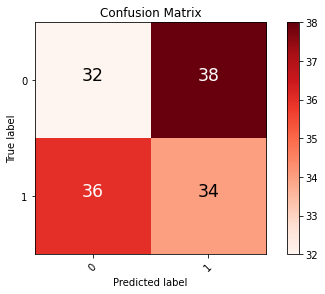

In [ ]:
n_splits = 4
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Scale data**

In [ ]:
# Scale data
for i in range(dyn_trials.shape[0]):
    scaler = StandardScaler()
    dyn_trials[i, :, :] = scaler.fit_transform(dyn_trials[i, :, :]) 

dyn_trials.shape

(2824, 1101, 64)

**Train on n-1 users**

In [ ]:
#train on all but one user
#in this case FM01
train_set = dyn_trials[(np.where(dyn_groups != '01'))]
test_set = dyn_trials[(np.where(dyn_groups == '01'))]

label_train = dyn_labels[(np.where(dyn_groups != '01'))]
label_test = dyn_labels[(np.where(dyn_groups == '01'))]

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

base_model = create_base_model()
#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
 - 17s - loss: 0.7141 - accuracy: 0.5186
Epoch 2/25
 - 17s - loss: 0.6957 - accuracy: 0.5387
Epoch 3/25
 - 17s - loss: 0.6966 - accuracy: 0.5093
Epoch 4/25
 - 17s - loss: 0.6967 - accuracy: 0.5160
Epoch 5/25
 - 17s - loss: 0.6975 - accuracy: 0.5052
Epoch 6/25
 - 16s - loss: 0.6927 - accuracy: 0.5283
Epoch 7/25
 - 16s - loss: 0.6925 - accuracy: 0.5503
Epoch 8/25
 - 16s - loss: 0.6870 - accuracy: 0.5678
Epoch 9/25
 - 16s - loss: 0.6809 - accuracy: 0.5626
Epoch 10/25
 - 16s - loss: 0.6621 - accuracy: 0.5991
Epoch 11/25
 - 16s - loss: 0.6147 - accuracy: 0.6416
Epoch 12/25
 - 16s - loss: 0.5259 - accuracy: 0.7269
Epoch 13/25
 - 16s - loss: 0.3651 - accuracy: 0.8346
Epoch 14/25
 - 16s - loss: 0.1769 - accuracy: 0.9285
Epoch 15/25
 - 16s - loss: 0.1152 - accuracy: 0.9557
Epoch 16/25
 - 16s - loss: 0.0825 - accuracy: 0.9732
Epoch 17/25
 - 16s - loss: 0.0723 - accuracy: 0.9762
Epoch 18/25
 - 16s - loss: 0.0344 - accuracy: 0.9877
Epoch 19/25
 - 16s - loss: 0.0332 - accuracy: 0.9888
Ep

**Apply transfer learning (and use K fold cross validation)**

Train on 105 samples, validate on 35 samples
Epoch 1/10
 - 1s - loss: 0.9256 - accuracy: 0.4286 - val_loss: 0.9515 - val_accuracy: 0.3429
Epoch 2/10
 - 1s - loss: 0.3205 - accuracy: 0.8095 - val_loss: 1.3376 - val_accuracy: 0.3429
Epoch 3/10
 - 1s - loss: 0.1074 - accuracy: 0.9619 - val_loss: 1.4685 - val_accuracy: 0.2857
Epoch 4/10
 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.5782 - val_accuracy: 0.2857
Epoch 5/10
 - 1s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.6021 - val_accuracy: 0.3714
Epoch 6/10
 - 1s - loss: 8.4434e-04 - accuracy: 1.0000 - val_loss: 1.6602 - val_accuracy: 0.3714
Epoch 7/10
 - 1s - loss: 4.6814e-04 - accuracy: 1.0000 - val_loss: 1.7052 - val_accuracy: 0.3429
Epoch 8/10
 - 1s - loss: 4.1478e-04 - accuracy: 1.0000 - val_loss: 1.7395 - val_accuracy: 0.3714
Epoch 9/10
 - 1s - loss: 3.4008e-04 - accuracy: 1.0000 - val_loss: 1.7779 - val_accuracy: 0.3714
Epoch 10/10
 - 1s - loss: 2.6673e-04 - accuracy: 1.0000 - val_loss: 1.8712 - val_accuracy: 0.3429
Trai

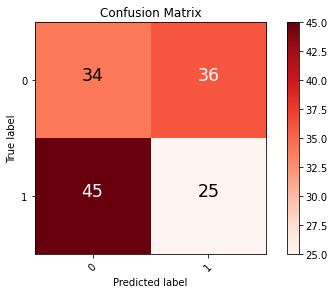

In [ ]:
n_splits = 4
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Give each user a chance to be the test set**

Epoch 1/25
 - 18s - loss: 1.2333 - accuracy: 0.4983
Epoch 2/25
 - 18s - loss: 0.6943 - accuracy: 0.5651
Epoch 3/25
 - 18s - loss: 0.6768 - accuracy: 0.5825
Epoch 4/25
 - 18s - loss: 0.6885 - accuracy: 0.5858
Epoch 5/25
 - 18s - loss: 0.6684 - accuracy: 0.6014
Epoch 6/25
 - 18s - loss: 0.6648 - accuracy: 0.6092
Epoch 7/25
 - 18s - loss: 0.6424 - accuracy: 0.6452
Epoch 8/25
 - 18s - loss: 0.5909 - accuracy: 0.6826
Epoch 9/25
 - 18s - loss: 0.5703 - accuracy: 0.6960
Epoch 10/25
 - 18s - loss: 0.5120 - accuracy: 0.7505
Epoch 11/25
 - 19s - loss: 0.4961 - accuracy: 0.7646
Epoch 12/25
 - 18s - loss: 0.3544 - accuracy: 0.8317
Epoch 13/25
 - 18s - loss: 0.3170 - accuracy: 0.8710
Epoch 14/25
 - 18s - loss: 0.2984 - accuracy: 0.8858
Epoch 15/25
 - 18s - loss: 0.2501 - accuracy: 0.9136
Epoch 16/25
 - 18s - loss: 0.1991 - accuracy: 0.9266
Epoch 17/25
 - 18s - loss: 0.0942 - accuracy: 0.9648
Epoch 18/25
 - 18s - loss: 0.0508 - accuracy: 0.9811
Epoch 19/25
 - 18s - loss: 0.0462 - accuracy: 0.9870
Ep

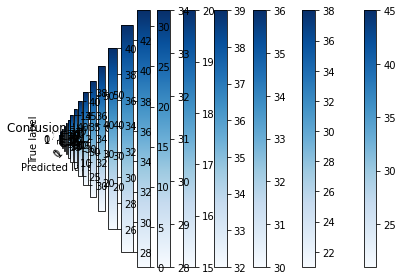

In [ ]:
#loop through all files, giving each one chance to be test set
for x in range(1,25):
  #there is no second user
  if x == 2:
    continue
  
  if x < 10:
    lone_user = '0' + str(x)
  else:
    lone_user = str(x)

  train_set = dyn_trials[(np.where(dyn_groups != lone_user))]
  test_set = dyn_trials[(np.where(dyn_groups == lone_user))]

  label_train = dyn_labels[(np.where(dyn_groups != lone_user))]
  label_test = dyn_labels[(np.where(dyn_groups == lone_user))]

  #train on n-1 users
  base_model = create_base_model()
  #fit model
  history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)
  
  #apply transfer learning
  tl_model = transfer_learning_model()

  #fit model
  tl_history = tl_model.fit(test_set, label_test, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

  #predictions of base model
  y_true = label_test
  y_pred_prob = base_model.predict(test_set)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0

  #evaluate original model on remaining user
  loss, acc = base_model.evaluate(test_set, label_test, batch_size=batch_size, verbose=verbose)
  print("FM" + str(x))
  print("%s: %.2f%%" % ("ACCURACY" , acc*100))
  print("LOSS: ", loss)

  #Plot confusion matrix
  conf_mat = confusion_matrix(y_true, y_pred, labels=class_names)
  plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Repeat transfer learning experiments with LSTM model**

**First with static files**

In [ ]:
#train on all but one user
#in this case FM01
train_set = static_trials[(np.where(static_groups != '01'))]
test_set = static_trials[np.where(static_groups == '01')] 

label_train = static_labels[(np.where(static_groups != '01'))]
label_test = static_labels[(np.where(static_groups == '01'))]  

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_lstm_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

Epoch 1/25
343/343 - 216s - loss: 1.2140 - accuracy: 0.5016
Epoch 2/25
343/343 - 222s - loss: 0.7297 - accuracy: 0.5455
Epoch 3/25
343/343 - 223s - loss: 0.6978 - accuracy: 0.5656
Epoch 4/25
343/343 - 224s - loss: 0.6753 - accuracy: 0.5736
Epoch 5/25
343/343 - 214s - loss: 0.6510 - accuracy: 0.6251
Epoch 6/25
343/343 - 226s - loss: 0.6231 - accuracy: 0.6620
Epoch 7/25
343/343 - 229s - loss: 0.7761 - accuracy: 0.6186
Epoch 8/25
343/343 - 223s - loss: 0.6624 - accuracy: 0.6003
Epoch 9/25
343/343 - 217s - loss: 0.6501 - accuracy: 0.6401
Epoch 10/25
343/343 - 221s - loss: 0.6328 - accuracy: 0.6525
Epoch 11/25
343/343 - 221s - loss: 0.6105 - accuracy: 0.6723
Epoch 12/25
343/343 - 223s - loss: 0.5980 - accuracy: 0.6774
Epoch 13/25
343/343 - 228s - loss: 0.7288 - accuracy: 0.6580
Epoch 14/25
343/343 - 220s - loss: 0.6086 - accuracy: 0.6686
Epoch 15/25
343/343 - 217s - loss: 0.5783 - accuracy: 0.7019
Epoch 16/25
343/343 - 222s - loss: 0.5431 - accuracy: 0.7282
Epoch 17/25
343/343 - 216s - loss

Epoch 1/10
111/111 - 9s - loss: 0.7195 - accuracy: 0.4955 - val_loss: 0.7267 - val_accuracy: 0.4286
Epoch 2/10
111/111 - 9s - loss: 0.6444 - accuracy: 0.7027 - val_loss: 0.7458 - val_accuracy: 0.3929
Epoch 3/10
111/111 - 9s - loss: 0.5760 - accuracy: 0.7297 - val_loss: 0.7950 - val_accuracy: 0.4286
Epoch 4/10
111/111 - 9s - loss: 0.5182 - accuracy: 0.7928 - val_loss: 0.8847 - val_accuracy: 0.3571
Epoch 5/10
111/111 - 9s - loss: 0.4436 - accuracy: 0.8649 - val_loss: 0.8951 - val_accuracy: 0.4286
Epoch 6/10
111/111 - 9s - loss: 0.3797 - accuracy: 0.8468 - val_loss: 0.9377 - val_accuracy: 0.4643
Epoch 7/10
111/111 - 9s - loss: 0.3215 - accuracy: 0.8829 - val_loss: 1.0847 - val_accuracy: 0.4643
Epoch 8/10
111/111 - 9s - loss: 0.2975 - accuracy: 0.8919 - val_loss: 1.1524 - val_accuracy: 0.4643
Epoch 9/10
111/111 - 9s - loss: 0.2675 - accuracy: 0.8919 - val_loss: 1.1920 - val_accuracy: 0.3929
Epoch 10/10
111/111 - 9s - loss: 0.2757 - accuracy: 0.8739 - val_loss: 1.1882 - val_accuracy: 0.3571

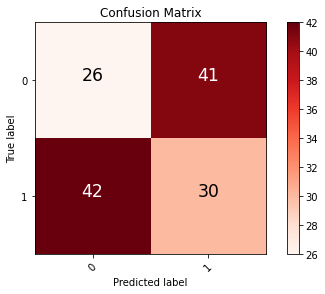

In [ ]:
n_splits = 5
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Repeat experiment with dynamic files**

In [ ]:
#train on all but one user
#in this case FM01
train_set = dyn_trials[(np.where(dyn_groups != '01'))]
test_set = dyn_trials[np.where(dyn_groups == '01')] 

label_train = dyn_labels[(np.where(dyn_groups != '01'))]
label_test = dyn_labels[(np.where(dyn_groups == '01'))]  

#vars for training
n_epochs = 25
batch_size = 8
verbose = 2

class_names = [0, 1]

base_model = create_lstm_model()

#fit model
history = base_model.fit(train_set, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size)

In [ ]:
n_splits = 5
n_epochs = 10
batch_size = 1

trues = []
preds = []
losses = []
accuracies = []
splits = []
split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(test_set):
  X_train, X_test = test_set[train_index], test_set[test_index]
  y_train, y_test = label_test[train_index], label_test[test_index]
  #apply transfer learning to base model
  model = get_tl_model(base_model)

  model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                 validation_data = (X_test, y_test))
  
  #predictions
  y_true = y_test
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #append to list
  trues.extend(y_true)
  preds.extend(y_pred)

  #evaluate model
  loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(acc * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", acc*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, preds, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')